In [1]:
import twitter
consumer_key = "Insert key here"
consumer_secret = "Insert key here"
access_token = "Insert key here"
access_token_secret = "Insert key here"
authorization = twitter.OAuth(access_token, access_token_secret, consumer_key, consumer_secret)
t = twitter.Twitter(auth=authorization, retry=True)

In [2]:
import os
data_folder = os.path.join(os.path.expanduser("~"), "Data", "twitter")
output_filename = os.path.join(data_folder, "python_tweets.json")

In [3]:
import json

In [4]:
original_users = []
tweets = []
user_ids = {}

search_results = t.search.tweets(q="python", count=100)['statuses']
for tweet in search_results:
    if 'text' in tweet:
        original_users.append(tweet['user']['screen_name'])
        user_ids[tweet['user']['screen_name']] = tweet['user']['id']
        tweets.append(tweet['text'])

In [5]:
len(tweets)

100

In [6]:
model_filename = os.path.join(os.path.expanduser("~"), "Models", "twitter", "python_context.pkl")

In [7]:
from sklearn.base import TransformerMixin
from nltk import word_tokenize

class NLTKBOW(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [{word: True for word in word_tokenize(document)}
                 for document in X]

In [8]:
from sklearn.externals import joblib
context_classifier = joblib.load(model_filename)

In [9]:
y_pred = context_classifier.predict(tweets)
y_pred

array([0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0])

In [10]:
relevant_tweets = [tweets[i] for i in range(len(tweets)) if y_pred[i] == 1]
relevant_users = [original_users[i] for i in range(len(tweets)) if y_pred[i] == 1]
print(len(relevant_tweets))

33


In [2]:
import time
import sys

def get_friends(t, user_id):
    friends = []
    cursor = -1  # Start with the first page
    while cursor != 0:  # If zero, that is the end:
        try:
            results = t.friends.ids(user_id=user_id, cursor=cursor, count=5000)
            friends.extend([friends for friends in results['ids']])
            cursor = results['next_cursor']
            if len(friends) >= 10000:
                break
            if cursor != 0:
                print("Collected {} friends so far, but there are more".format(len(friends)))
                sys.stdout.flush
        except TypeError as e:
            if results is None:
                print("You probably reached your API limit, waiting for 5 minutes")
                sys.stdout.flush()
                time.sleep(5*60) # 5 minute wait
            else:
                raise e
        except twitter.TwitterHTTPError as e:
            break
        finally:
            time.sleep(60)  # Wait 1 minute before continuing
    return friends


In [ ]:

test_friends = get_friends(t, user_ids[relevant_users[0]])
print(test_friends)

In [18]:
friends = {}
for screen_name in relevant_users:
    print("Obtaining friends for user {}".format(user))
    sys.stdout.flush()
    user_id = user_id[user]
    friends[user_id] = get_friends(t, user_id)
friends = {user_id:friends[user_id] for user_id in friends
             if len(friends[user_id]) > 0}

Obtaining friends for user ionelmc
Obtaining friends for user lauren_leclaire
Obtaining friends for user meguri_796
Obtaining friends for user ticketsflying
Obtaining friends for user AllTechBot
Obtaining friends for user VTCVillage
Obtaining friends for user findmjob
Obtaining friends for user rapitup204
Obtaining friends for user rapitup204
Obtaining friends for user rapitup204
Obtaining friends for user rapitup204
Obtaining friends for user projectsuperior
Obtaining friends for user jobely
Obtaining friends for user python_job_feed
Obtaining friends for user _TrabajoMadrid_
Obtaining friends for user Empleo_enMadrid
Obtaining friends for user ReptileInsider1
Obtaining friends for user HeatherA789
Obtaining friends for user AB_2412
Obtaining friends for user OurNBASpurs
Obtaining friends for user satoho_177
Obtaining friends for user spantreellc
Obtaining friends for user divideby0
Obtaining friends for user honatu_956
Obtaining friends for user MayaDelany
Obtaining friends for user 

In [3]:
from collections import defaultdict

In [4]:
def count_friends(friends):
    friend_count = defaultdict(int)
    for friend_list in friends.values():
        for friend in friend_list:
            friend_count[friend] += 1
    return friend_count

In [5]:
#TODO: Remove before production
import os
import json

data_folder = os.path.join(os.path.expanduser("~"), "Data", "twitter")
friends_filename = os.path.join(data_folder, "python_friends.json")
with open(friends_filename) as inf:
    friends = json.load(inf)

In [6]:
friend_count = count_friends(friends)

In [7]:
from operator import itemgetter
best_friends = sorted(friend_count.items(), key=itemgetter(1), reverse=True)

In [8]:
best_friends[:10]

[(1533877544, 21),
 (1437397166, 18),
 (264158124, 18),
 (838820264, 18),
 (2205707677, 17),
 (2222807107, 17),
 (1963872133, 17),
 (2294262750, 17),
 (174087579, 16),
 (1423236582, 16)]

In [20]:
while len(friends) < 150:
    # Get the best friend that isn't already in our list
    for user_id, count in best_friends:
        if user_id not in friends and str(user_id) != '467407284':
            break
    print("Getting friends of user {}".format(user_id))
    sys.stdout.flush()
    friends[user_id] = get_friends(t, user_id)
    print("Received {} friends".format(len(friends[user_id])))
    print("We now have the friends of {} users".format(len(friends)))
    sys.stdout.flush()
    # Update friend_count
    for friend in friends[user_id]:
        friend_count[friend] += 1
    # Update the best friends list
    best_friends = sorted(friend_count.items(), key=itemgetter(1), reverse=True)

Getting friends of user 2540917573
Collected 5000 friends so far, but there are more
Received 10000 friends
We now have the friends of 98 users
Getting friends of user 2715520412
Collected 5000 friends so far, but there are more
Received 10000 friends
We now have the friends of 99 users
Getting friends of user 2323494632
Collected 5000 friends so far, but there are more
Received 10000 friends
We now have the friends of 100 users
Getting friends of user 2279999317
Received 3990 friends
We now have the friends of 101 users
Getting friends of user 2527724792
Collected 5000 friends so far, but there are more
Received 8171 friends
We now have the friends of 102 users
Getting friends of user 272305232
Collected 5000 friends so far, but there are more
Received 10000 friends
We now have the friends of 103 users
Getting friends of user 2857719008
Collected 5000 friends so far, but there are more
Received 10000 friends
We now have the friends of 104 users
Getting friends of user 2420119549
Colle

In [21]:
import json
friends_filename = os.path.join(data_folder, "python_friends.json")
with open(friends_filename, 'w') as outf:
    json.dump(friends, outf)

In [22]:
import networkx as nx
G = nx.DiGraph()

main_users = friends.keys()
G.add_nodes_from(main_users)

for user_id in friends:
    for friend in friends[user_id]:
        if friend in main_users:
           G.add_edge(user_id, friend) 
G

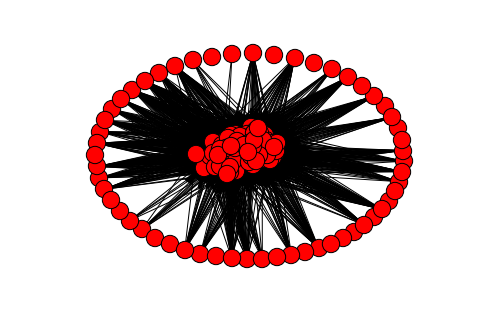

In [23]:
%matplotlib inline
nx.draw(G)

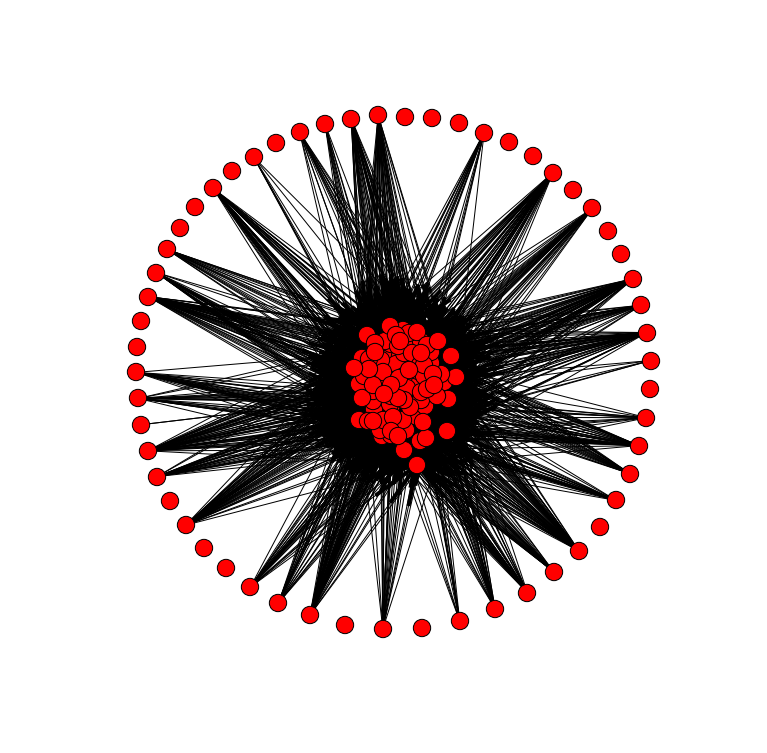

In [24]:
from matplotlib import pyplot as plt
plt.figure(3,figsize=(10, 10))
nx.draw(G)